In [1]:
# 本节将介绍注意力汇聚的更多细节， 以便从宏观上了解注意力机制在实践中的运作方式。 
# 具体来说，1964年提出的Nadaraya-Watson核回归模型 是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [3]:
# 考虑一个回归问题，对一个成对的“输入－输出”数据集 x1,y1 ; x2,y2....
# 如何学习f来预测任意新输入x的输出fx?
# 数据集用函数 fx = 2sin(xi) + (xi)^0.8 + 扰动(满足0,0.5的正太分布)

In [4]:
n_train = 50
# torch.sort 会返回两个值：排序后的tensor, 原值的index
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 0-1

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

In [5]:
# 下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数
#（标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5]) # xlim = x limits 表示x的范围
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

In [7]:
# 先使用最简单的估计器来解决回归问题。 基于平均汇聚来计算所有训练样本输出值的平均值

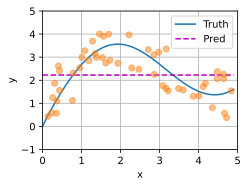

In [8]:
# repeat 重复 repeat_interleave 交错重复
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [9]:
# 显然不太聪明，这条紫色虚线

In [10]:
# 我们不去过多介绍这个Nadaraya-Watson核回归模型的公式
# 但是我们可以从注意力的角度重写这个公式：
# f(x) = Σα(x, xi)yi
# x是查询, xi,yi是键值对，注意力汇聚是yi的加权平均
# 将查询x于xi之间的关系建模为注意力权重 α(x,xi),分配给每一个yi
# ps：x 和 xi 更像，那yi就会有更高的权值，那我就会更关注它
# 对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布： 它们是非负的，并且总和为1。

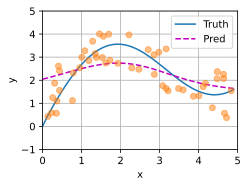

In [11]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = F.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [12]:
# 上面的注释是原文写的，太乱了，我整理一下
# 1.我先把x_test(测试用数据，真实)变成(n_test,n_train)维度
# 2.算attention值，x_train是一维，但是会被广播，从(n_train,)被广播
# 3.所以这一步再算的，是每个x,和x_train 中 xi的距离 f(x) = Σα(x, xi)yi
# 4.在找你这个x啊，跟我数据里面有的xi,哪个更接近呢
# 5.所以才需要这么n_train列，不然我没法一个个比较呢
# 6.有了相似矩阵attention_weight, 我就可以乘以y_train真实值了
# y_hat = torch.matmul(attention_weights, y_train) 这一步会尽可能往y_train靠拢
X_repeat.shape,X_repeat[0], attention_weights.shape,attention_weights[0],

(torch.Size([50, 50]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 torch.Size([50, 50]),
 tensor([6.3342e-02, 6.2252e-02, 6.1836e-02, 6.0948e-02, 6.0036e-02, 5.9767e-02,
         5.8875e-02, 5.8225e-02, 5.8169e-02, 4.7669e-02, 4.6898e-02, 4.0545e-02,
         3.8516e-02, 3.5566e-02, 3.1633e-02, 2.8074e-02, 2.5741e-02, 2.4618e-02,
         2.2058e-02, 1.9768e-02, 1.8894e-02, 1.7233e-02, 1.5171e-02, 1.4376e-02,
         9.9377e-03, 5.4947e-03, 4.6880e-03, 3.0371e-03, 1.6336e-03, 1.0857e-03,
         1.0571e-03, 7.5425e-04, 5.5399e-04, 4.2400e-04, 4.2280e-04, 3.6173e-04,
         1.4682e-04, 9.7038e-05, 3.6308e-05, 2.0841e-05, 1.3436e-05, 1.0447e-05,
         4.9066e-06, 2.8782e-06, 2.8114e-06, 1.3745e-06, 1.3168e-06, 1.2138e-06,
         9.4567e-07, 5.3736e-07]))

In [13]:
# 现在来观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 
# 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高

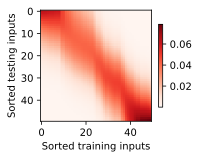

In [14]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [15]:
# 非参数的Nadaraya-Watson核回归具有一致性（consistency）的优点： 
# 如果有足够的数据，此模型会收敛到最优结果
# 但我们可以合成可学习的参数，为什么不呢
# 比如，我可以插入一个可学习参数w,在x与xi的距离间插入w

In [16]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
X, torch.bmm(X, Y).shape, torch.matmul(X,Y).shape #bmm: batch matrix multiple

(tensor([[[1., 1., 1., 1.]],
 
         [[1., 1., 1., 1.]]]),
 torch.Size([2, 1, 6]),
 torch.Size([2, 1, 6]))

In [17]:
#在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [18]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2,10))
# unsqueeze(1)在第一维地方直接插进去一维，(-1)在最后一维地方插一维
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))
# (2,1,10) @ (2,10,1)

tensor([[[ 4.5000]],

        [[14.5000]]])

In [19]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [20]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1)) # 第1维重复一次
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
# 做了个蒙版，把自己那一个数字都去掉了，从3,3变成了3,2
# 也就是说，在算x xi相似度的时候，不会把自己算进去了
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

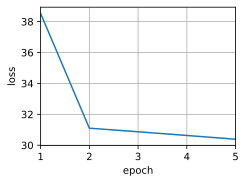

In [27]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

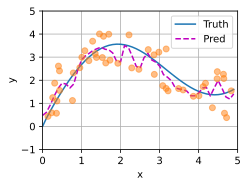

In [30]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).detach()
plot_kernel_reg(y_hat)

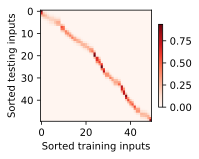

In [31]:
# 为什么新的模型更不平滑了呢？
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [ ]:
#  与非参数的注意力汇聚模型相比， 带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑